In [64]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from functools import reduce
import statistics

In [65]:
nqubit = 1
c_depth = 1
time_step = 10

x_min = -1.
x_max = 1.
num_x_train = 50

func_to_learn = lambda x: x**3

random_seed = 8
np.random.seed(random_seed)

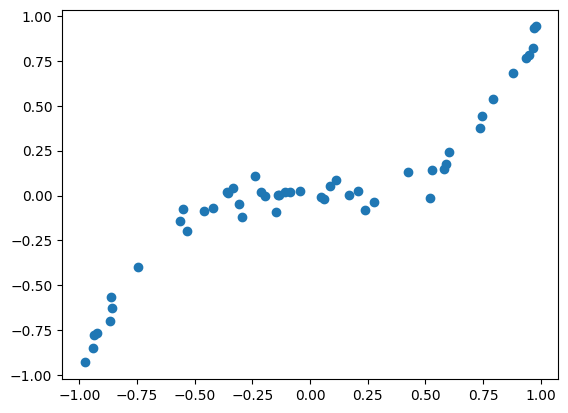

In [66]:
x_train = x_min + (x_max - x_min)*np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

mag_noise = 0.05
y_train = y_train+ mag_noise * np.random.randn(num_x_train)

plt.plot(x_train,y_train,"o")
plt.show()


In [67]:
from qulacs import QuantumState,QuantumCircuit

state = QuantumState(nqubit)
state.set_zero_state()

def U_in(x):
    U = QuantumCircuit(nqubit)
    
    angle_y = np.arcsin(x)
    angel_z = np.arccos(x**2)
    
    for i in range(nqubit):
        U.add_RY_gate(i,angle_y)
        U.add_RZ_gate(i,angel_z)
    
    return U

In [68]:
from qulacs.gate import X,Z,RX,RZ
I_mat = np.eye(2,dtype = complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

In [69]:
def make_fullgate(list_SiteAndOperator,nqubit):
    list_Site = []
    for siteAndOperator in list_SiteAndOperator:
        list_Site.append(siteAndOperator[0])
        
    list_singleGate  =  []
    cnt = 0
    for i in range(nqubit):
        if(i in list_Site):
            list_singleGate.append(list_SiteAndOperator[cnt][1])
            cnt += 1
        else:
            list_singleGate.append(I_mat)
            
    return reduce(np.kron,list_singleGate)

In [70]:
ham = np.zeros((2**nqubit,2**nqubit),dtype = complex)
for i in range(nqubit):
    Jx = -1. + 2.*np.random.rand()
    ham += Jx * make_fullgate([[i,X_mat]],nqubit)
    for j in range(i):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate([[i,Z_mat],[j,Z_mat]],nqubit)
        
diag,eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs,np.diag(np.exp(-1j*time_step*diag))),eigen_vecs.T.conj())

In [71]:
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)],time_evol_op)

In [72]:
from qulacs import ParametricQuantumCircuit

U_out =  ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        

In [73]:
parameter_count = U_out.get_parameter_count()
U_out_gra0 = []
U_out_gra1 = []
for i in range(parameter_count):
    U_out_gra0.append(ParametricQuantumCircuit(nqubit))
    U_out_gra1.append(ParametricQuantumCircuit(nqubit))
    
angle = 0

for j in range(parameter_count):
    for d in range(c_depth):
        U_out_gra0[j].add_gate(time_evol_gate)
        for i in range(nqubit):
            
            if(3*nqubit*d + 3*i == j):
                U_out_gra0[j].add_parametric_RX_gate(i,np.pi/2)
            U_out_gra0[j].add_parametric_RX_gate(i,angle)
            
            if(3*nqubit*d + 3*i +1== j):
                U_out_gra0[j].add_parametric_RZ_gate(i,np.pi/2)
            U_out_gra0[j].add_parametric_RZ_gate(i,angle)
            
            if(3*nqubit*d + 3*i +2== j):
                U_out_gra0[j].add_parametric_RX_gate(i,np.pi/2)
            U_out_gra0[j].add_parametric_RX_gate(i,angle)    
            
            

for j in range(parameter_count):
    for d in range(c_depth):
        U_out_gra1[j].add_gate(time_evol_gate)
        for i in range(nqubit):
            
            if(3*nqubit*d + 3*i == j):
                U_out_gra1[j].add_parametric_RX_gate(i,-1*np.pi/2)
            U_out_gra1[j].add_parametric_RX_gate(i,angle)
            
            if(3*nqubit*d + 3*i +1== j):
                U_out_gra1[j].add_parametric_RZ_gate(i,-1*np.pi/2)
            U_out_gra1[j].add_parametric_RZ_gate(i,angle)
            
            if(3*nqubit*d + 3*i +2== j):
                U_out_gra1[j].add_parametric_RX_gate(i,-1*np.pi/2)
            U_out_gra1[j].add_parametric_RX_gate(i,angle)  


In [74]:
parameter_count = U_out.get_parameter_count()
print(parameter_count)
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

3


In [75]:
def set_U_out(theta):
    global U_out
    parameter_count = U_out.get_parameter_count()
    for i in range(parameter_count):
        U_out.set_parameter(i,theta[i])

In [76]:
def set_U_out_gra(theta):
    global U_out_gra0
    global U_out_gra1
    for i in range(U_out.get_parameter_count()):
        for j in range(U_out.get_parameter_count()):
            if(j < i):
                U_out_gra0[i].set_parameter(j,theta[j])
                U_out_gra1[i].set_parameter(j,theta[j])
            
            else:
                print(j+1)
                U_out_gra0[i].set_parameter(j+1,theta[j])
                U_out_gra1[i].set_parameter(j+1,theta[j])

In [77]:
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2.,'Z 0')

In [78]:
def qcl_pred(x,U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()
    
    U_in(x).update_quantum_state(state)
    U_out.update_quantum_state(state)
    res = obs.get_expectation_value(state)
    
    return res

In [79]:
def cost_func(theta):
    set_U_out(theta)
    y_pred = [qcl_pred(x,U_out) for x in x_train]
    L = ((y_pred - y_train)**2).mean()
    return L

In [80]:
def cost_func_gra(theta):
    set_U_out(theta)
    set_U_out_gra(theta)
    y_pred = [qcl_pred(x,U_out) for x in x_train]
    L_grad = []
    
    for i in range(parameter_count):
        y_pred_gra0 = [qcl_pred(x,U_out_gra0[i]) for x in x_train]
        y_pred_gra1 = [qcl_pred(x,U_out_gra1[i]) for x in x_train]
        cost = []
        for j in range(num_x_train):
            cost.append((y_pred[j]- y_train[j])*(y_pred_gra0[j] - y_pred_gra1[j]))
        L_grad.append(statistics.mean(cost))
                           
    return L_grad

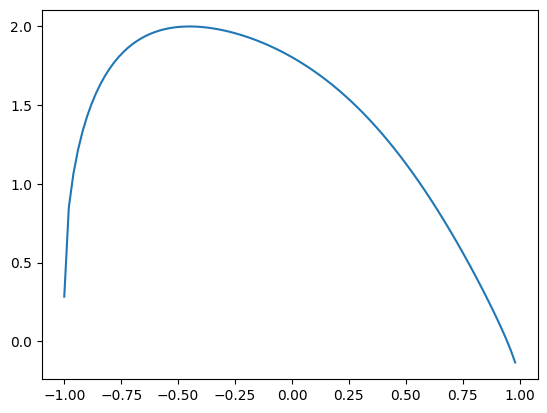

In [81]:
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

In [82]:
from scipy.optimize import minimize
result = minimize(cost_func,theta_init, method='nelder-mead')

In [83]:
print(result.fun)
theta_opt = result.x
print(theta_opt)

0.061677759632031925
[4.62188851 7.47764113 4.93999989]


In [84]:
print(U_out.get_gate_count())

4


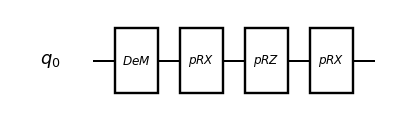

In [85]:
from qulacsvis import circuit_drawer
from qulacs import QuantumCircuit
# Add gates to the circuit
...
circuit_drawer(U_out, "mpl")


In [86]:
# from qulacs_core.gate import  RX,RZ,to_matrix_gate
# full_gate = []
# full_gate2 = []
# for d in range(c_depth):
#     for i in range(nqubit):
#         mat = to_matrix_gate(RX(0,theta_opt[3*nqubit*d+3*i]))
#         mat0 = mat.get_matrix() 
#         mat = to_matrix_gate(RZ(0,theta_opt[3*nqubit*d+3*i+1]))
#         mat1 = mat.get_matrix()
#         mat = to_matrix_gate(RX(0,theta_opt[3*nqubit*d+3*i+2]))
#         mat2 = mat.get_matrix()
        
#         mat_out = np.dot(mat2,np.dot(mat1,mat0))
#         full_gate.append(mat_out)

# final = np.eye(2**nqubit,dtype = complex)

# for i in range(c_depth):
#     final = np.dot(time_evol_op,final)
#     rot = make_fullgate([[0,full_gate[nqubit*i]]],nqubit)
#     final = np.dot(rot,final)

# print(final)


In [87]:
from qulacs_core.gate import  RX,RZ,to_matrix_gate
print(len(theta_opt))
final = np.eye(2,dtype = complex)
mat0 = to_matrix_gate(RX(0,theta_opt[0])).get_matrix()
mat1 = to_matrix_gate(RZ(0,theta_opt[1])).get_matrix()
mat2 = to_matrix_gate(RX(0,theta_opt[2])).get_matrix()

print(mat0)
print(mat1)
print(mat2)
    
rot = np.dot(mat2,np.dot(mat1,mat0))
final = np.dot(rot,np.dot(time_evol_op,final))

print(final)

3
[[-0.67439714+0.j          0.        +0.73836881j]
 [ 0.        +0.73836881j -0.67439714+0.j        ]]
[[-0.82689768-0.56235241j  0.        +0.j        ]
 [ 0.        +0.j         -0.82689768+0.56235241j]]
[[-0.78283162+0.j         0.        +0.6222336j]
 [ 0.        +0.6222336j -0.78283162+0.j       ]]
[[ 0.66645727-0.22202591j -0.51666694+0.48948389j]
 [ 0.51666694+0.48948389j  0.66645727+0.22202591j]]


In [88]:
def test_pred(x):
    qc = QuantumCircuit(1)
    state = QuantumState(1)
    state.set_zero_state()
    
    gate_test = DenseMatrix([0],final)
     
    qc.add_RY_gate(0,np.arcsin(x))
    qc.add_RZ_gate(0,np.arccos(x**2))
    
    qc.add_gate(time_evol_gate)
    
    qc.add_RX_gate(0,theta_opt[0])
    qc.add_RZ_gate(0,theta_opt[1])
    qc.add_RX_gate(0,theta_opt[2])
    
    qc.update_quantum_state(state)
    
    
    
    Pauil_string = "Z 0"
    observable1 = Observable(1)
    observable1.add_operator(2.0,Pauil_string)

    value = observable1.get_expectation_value(state)
    
    return value


In [89]:
a = 0.5*((np.abs(final[0][0]))**2 + (np.abs(final[1][1]))**2 - (np.abs(final[0][1]))**2 - (np.abs(final[1][0]))**2)
b = final[0][0]*np.conj(final[0][1]) - final[1][0]*np.conj(final[1][1])
c = -1.*np.real(b)
d = np.imag(b)

fun_ap = lambda x:2*(a*np.sqrt(1-x**2) + c*x**3 + d*x*np.sqrt(1-x**4))

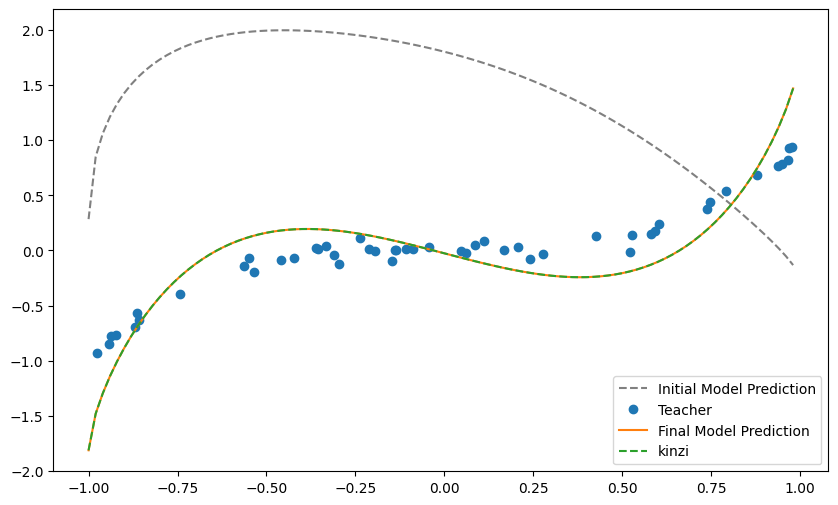

In [91]:
set_U_out(theta_opt)
plt.figure(figsize=(10,6))
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')
plt.plot(x_train, y_train, "o", label='Teacher')

y_pred = np.array([qcl_pred(x, U_out) for x in xlist])
y_pred2 = np.array([fun_ap(x) for x in xlist])
pred3 = np.array([test_pred(x) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')
plt.plot(xlist, y_pred2, '--', label='kinzi')
# plt.plot(xlist, pred3, label='matrix')

plt.legend()
plt.show()